`python3 export.py --weights weights/yolov7-mask.pt --img-size 640 640 --batch-size 1 --grid --end2end --max-wh 640 --simplify --mask --cleanup --topk-all 100 --iou-thres 0.65 --conf-thres 0.35 --trt`

`python3 export.py --weights weights/yolov7-mask.pt --img-size 640 640 --batch-size 1 --grid --end2end --max-wh 640 --simplify --mask --cleanup`

`/usr/src/tensorrt/bin/trtexec --onnx=./weights/yolov7-mask.onnx --saveEngine=./weights/yolov7-mask-nms.trt --workspace=8192`

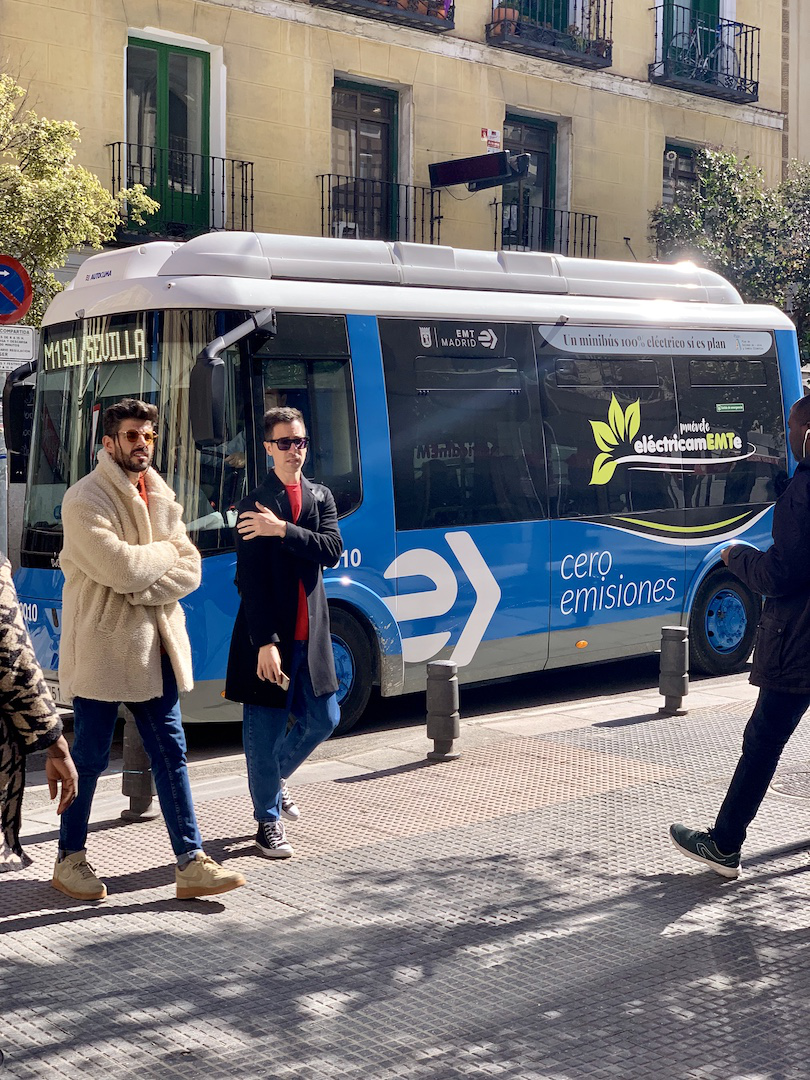

In [1]:
from PIL import Image

Image.open("../inference/images/bus.jpg")

In [2]:
import cv2
import torch
import random
import time
import numpy as np
import tensorrt as trt
from PIL import Image
from pathlib import Path
from collections import OrderedDict, namedtuple

/home/jovyan/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
w = "../weights/yolov7-mask-nms.trt"
device = torch.device("cuda:0")
img = cv2.imread("../inference/images/bus.jpg")

In [4]:
# Infer TensorRT Engine
Binding = namedtuple("Binding", ("name", "dtype", "shape", "data", "ptr"))
logger = trt.Logger(trt.Logger.INFO)
trt.init_libnvinfer_plugins(logger, namespace="")
with open(w, "rb") as f, trt.Runtime(logger) as runtime:
    model = runtime.deserialize_cuda_engine(f.read())
bindings = OrderedDict()
for index in range(model.num_bindings):
    name = model.get_binding_name(index)
    dtype = trt.nptype(model.get_binding_dtype(index))
    shape = tuple(model.get_binding_shape(index))
    data = torch.from_numpy(np.empty(shape, dtype=np.dtype(dtype))).to(device)
    bindings[name] = Binding(name, dtype, shape, data, int(data.data_ptr()))
binding_addrs = OrderedDict((n, d.ptr) for n, d in bindings.items())
context = model.create_execution_context()

In [5]:
def letterbox(
    im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32
):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(
        im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color
    )  # add border
    return im, r, (dw, dh)

In [6]:
def postprocess(boxes, r, dwdh):
    dwdh = torch.tensor(dwdh * 2).to(boxes.device)
    boxes -= dwdh
    boxes /= r
    return boxes

In [7]:
names = [
    "person",
    "bicycle",
    "car",
    "motorcycle",
    "airplane",
    "bus",
    "train",
    "truck",
    "boat",
    "traffic light",
    "fire hydrant",
    "stop sign",
    "parking meter",
    "bench",
    "bird",
    "cat",
    "dog",
    "horse",
    "sheep",
    "cow",
    "elephant",
    "bear",
    "zebra",
    "giraffe",
    "backpack",
    "umbrella",
    "handbag",
    "tie",
    "suitcase",
    "frisbee",
    "skis",
    "snowboard",
    "sports ball",
    "kite",
    "baseball bat",
    "baseball glove",
    "skateboard",
    "surfboard",
    "tennis racket",
    "bottle",
    "wine glass",
    "cup",
    "fork",
    "knife",
    "spoon",
    "bowl",
    "banana",
    "apple",
    "sandwich",
    "orange",
    "broccoli",
    "carrot",
    "hot dog",
    "pizza",
    "donut",
    "cake",
    "chair",
    "couch",
    "potted plant",
    "bed",
    "dining table",
    "toilet",
    "tv",
    "laptop",
    "mouse",
    "remote",
    "keyboard",
    "cell phone",
    "microwave",
    "oven",
    "toaster",
    "sink",
    "refrigerator",
    "book",
    "clock",
    "vase",
    "scissors",
    "teddy bear",
    "hair drier",
    "toothbrush",
]
colors = {
    name: [random.randint(0, 255) for _ in range(3)] for i, name in enumerate(names)
}

In [8]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image = img.copy()
image, ratio, dwdh = letterbox(image, auto=False)
image = image.transpose((2, 0, 1))
image = np.expand_dims(image, 0)
image = np.ascontiguousarray(image)
im = image.astype(np.float32)
im.shape

(1, 3, 640, 640)

In [9]:
im = torch.from_numpy(im).to(device)
im /= 255.0
im.shape

# warmup for 10 times
for _ in range(10):
    tmp = torch.randn(1, 3, 640, 640).to(device)
    binding_addrs["images"] = int(tmp.data_ptr())
    context.execute_v2(list(binding_addrs.values()))

start = time.perf_counter()
binding_addrs["images"] = int(im.data_ptr())
context.execute_v2(list(binding_addrs.values()))
print(f"Cost {time.perf_counter()-start} s")

Cost 0.04613245907239616 s


In [16]:
nums = bindings["num_dets"].data
boxes = bindings["det_boxes"].data
scores = bindings["det_scores"].data
classes = bindings["det_classes"].data
masks = bindings["det_mask"].data

nums.shape, boxes.shape, scores.shape, classes.shape, masks.shape

(torch.Size([1]),
 torch.Size([1, 100, 4]),
 torch.Size([1, 100, 1]),
 torch.Size([1, 100, 1]),
 torch.Size([1, 100, 3136]))

In [17]:
nums[0]

tensor(5, device='cuda:0', dtype=torch.int32)

In [18]:
boxes = boxes[0, : nums[0]]
scores = scores[0, : nums[0]]
classes = classes[0, : nums[0]]
masks = masks[0, : nums[0]].reshape(-1, 1, 56, 56)

boxes.shape, scores.shape, classes.shape, masks.shape

(torch.Size([5, 4]),
 torch.Size([5, 1]),
 torch.Size([5, 1]),
 torch.Size([5, 1, 56, 56]))

In [19]:
from torchvision.models.detection.roi_heads import paste_masks_in_image

pred_masks = paste_masks_in_image(masks, boxes, (640, 640))
pred_masks[pred_masks < 0.5] = 0
pred_masks[pred_masks > 0.5] = 1

pred_masks = pred_masks.reshape(-1, 1, 640, 640)

In [20]:
boxes = boxes.cpu().numpy()
scores = scores.cpu().numpy()
classes = classes.cpu().numpy()
pred_masks = pred_masks.cpu().numpy().astype(np.bool).reshape(-1, 640, 640)

In [21]:
image.shape

(1, 3, 640, 640)

In [22]:
nimg = image[0].copy().transpose(1, 2, 0)
nimg = nimg.astype(np.uint8)
# nimg = cv2.cvtColor(nimg, cv2.COLOR_BGR2RGB)

pnimg = nimg.copy()
pnimg.shape

(640, 640, 3)

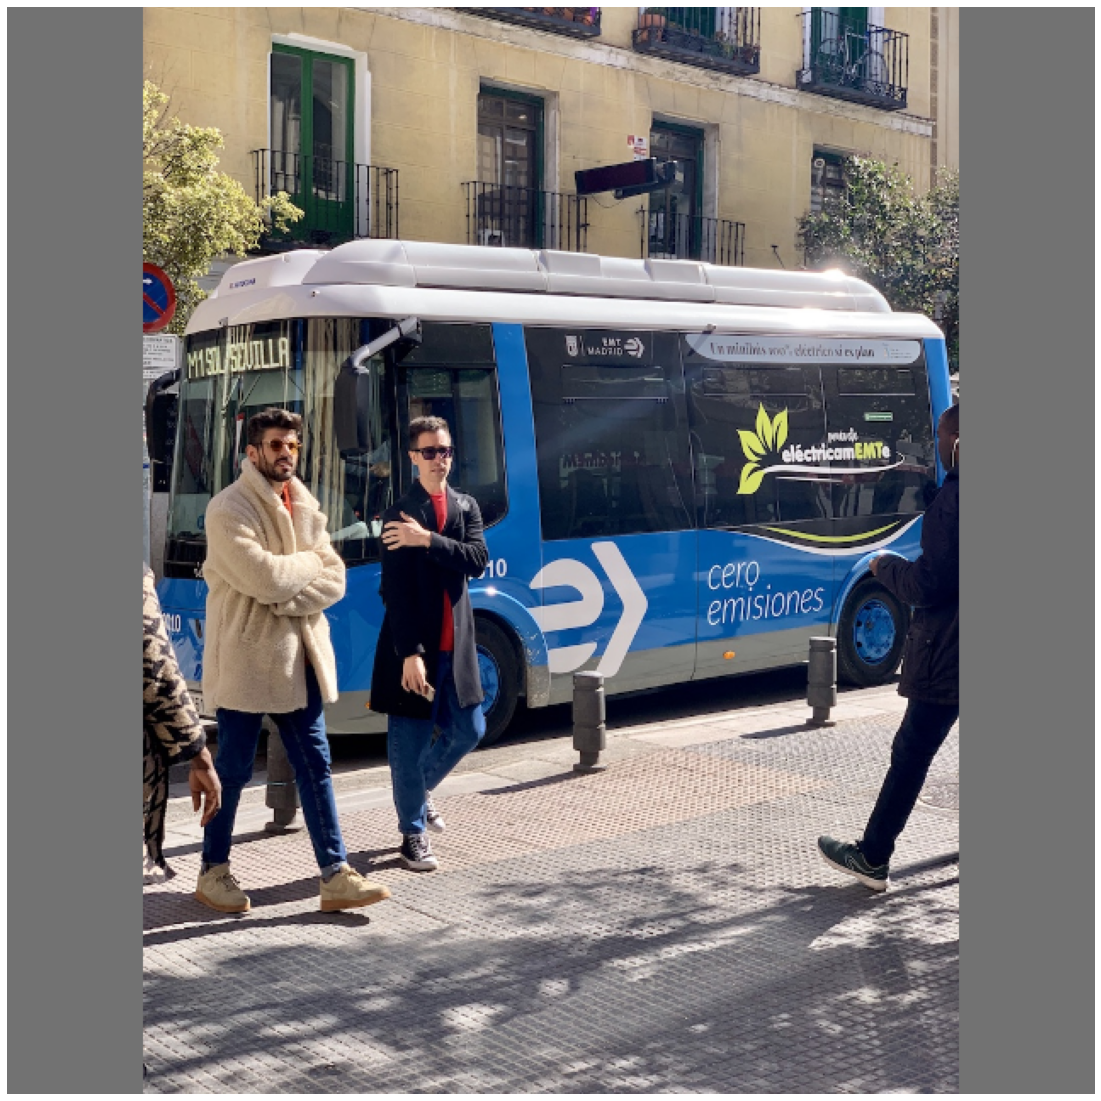

In [23]:
import matplotlib.pyplot as plt

# coco example
%matplotlib inline
plt.figure(figsize=(20, 20))
plt.axis("off")
plt.imshow(pnimg)
plt.show()

In [24]:
for bbox, score, cls, mask in zip(boxes, scores, classes, pred_masks):
    if score < 0.25:
        continue

    color = [np.random.randint(255), np.random.randint(255), np.random.randint(255)]

    pnimg[mask] = pnimg[mask] * 0.5 + np.array(color, dtype=np.uint8) * 0.5

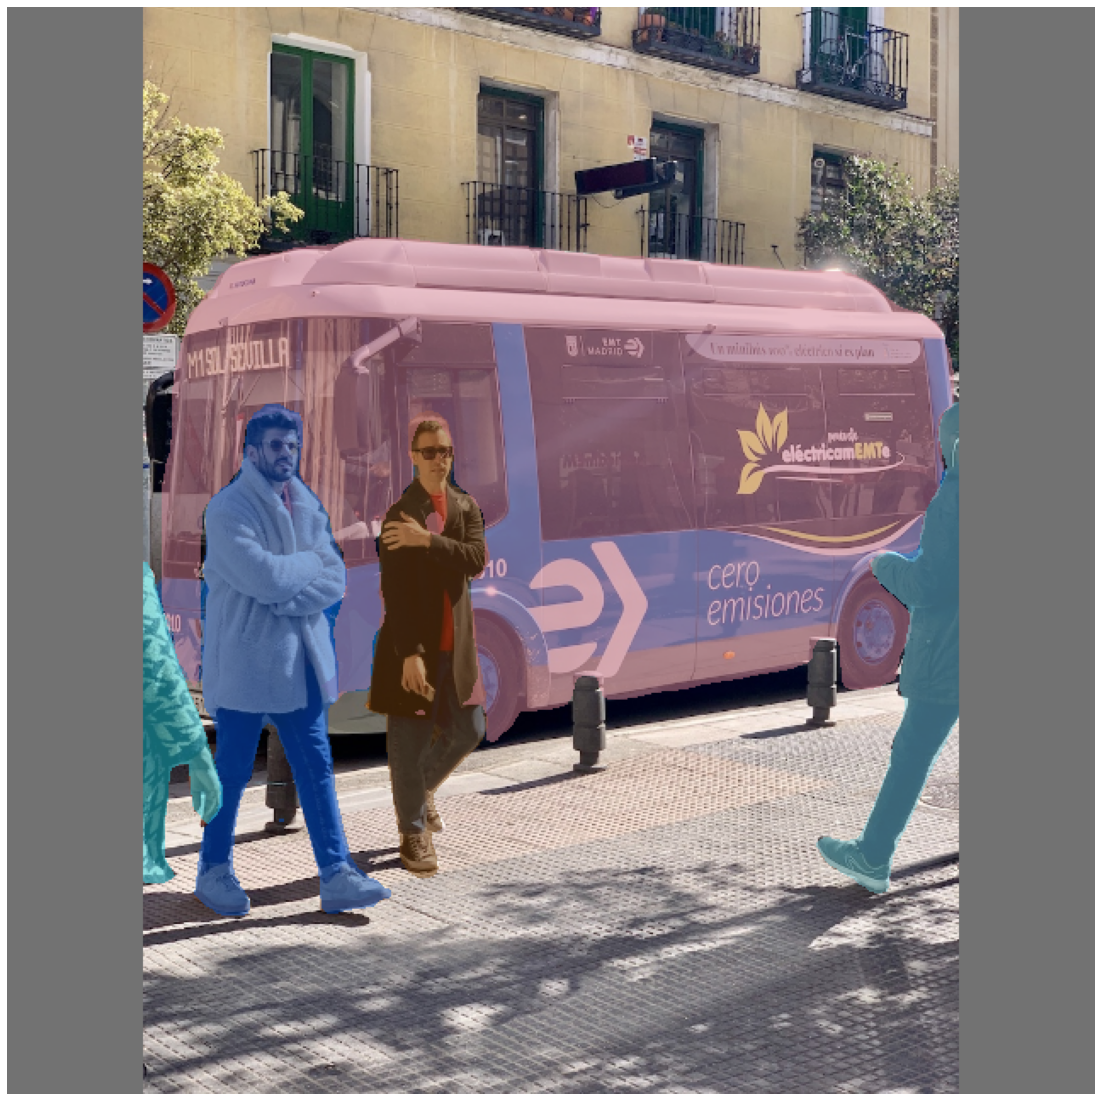

In [25]:
import matplotlib.pyplot as plt

# coco example
%matplotlib inline
plt.figure(figsize=(20, 20))
plt.axis("off")
plt.imshow(pnimg)
plt.show()